# Recipe site traffic prediction

**In this project, I trained a machine learning model that can predict weather a recipe will be high trafficked or not**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [1]:
# importation of the modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV


recipe_data = pd.read_csv("recipe_site_traffic_2212.csv")
print(recipe_data.head())
print(recipe_data.info())

   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85  ...  Beverages         4          NaN

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes

**Description of Preprocessing the Target Variable "high_traffic":**

In the dataset, the "high_traffic" column is a categorical variable that indicates whether the traffic to the site was high when a recipe was shown. The values in this column are represented as "High" if the traffic was high and are marked as missing (NaN) if this information is not available.

Since we need to categorize the traffic into two distinct classes and the dataset contains only "High" and NaN values, I have chosen to transform the missing values into the "Low" category. This helps create a clear distinction between recipes that experienced high traffic and those that did not, making it suitable for binary classification.

To achieve this, I used the following steps in Python:


In [2]:
recipe_data['high_traffic'] =  recipe_data['high_traffic'].fillna('Low')
recipe_data['high_traffic'].value_counts()

High    574
Low     373
Name: high_traffic, dtype: int64

**Explanation of Numerical Columns Preprocessing:**

In the dataset, the columns ['calories', 'carbohydrate', 'sugar', 'protein'] represent essential nutritional information for each recipe. It's noticed that each of these columns contains 52 missing values.

To handle these missing values, I opted for a practical approach using the median value of each column. I chose the median because it's less influenced by any unusual values that might exist (outliers). This approach maintains the central tendency of the data while minimizing the impact of outliers.

To achieve this, I created a function called `fill_na`. This function takes two inputs: the dataset and the name of the column to process. It calculates the median of the column and fills in the missing values with this median value.

Here's the code I used for the numerical columns' preprocessing:



In [3]:
# a function to fill the missing values in the numerical columns
def fill_na(data, col):
    return data[col].fillna(data[col].median())

cols = ['calories', 'carbohydrate', 'sugar', 'protein']

for col in cols:
    recipe_data[col] = fill_na(recipe_data, col)
    


**Explanation of Categorical Column Preprocessing for 'category':**

The 'category' column in the dataset ideally should contain specific categories, including 'Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', and 'One Dish Meal'. However, upon examining the data, I noticed that there are variations like 'Chicken Breast' that need to be standardized.

To achieve this, I will use an alternative method where I'll replace specific text patterns in the 'category' column. Specifically, I will remove the word 'Breast' from categories that contain it, effectively transforming 'Chicken Breast' into 'Chicken'. This method is more practical and efficient than manually mapping each variation.

Here's the code I used to implement this approach:


In [4]:

recipe_data['category'] = recipe_data['category'].str.replace(' Breast', '')


desired_categories = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat',
                      'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal']
recipe_data = recipe_data[recipe_data['category'].isin(desired_categories)]

print(recipe_data['category'].unique())
print(recipe_data['category'].shape)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
(947,)


**Explanation of Extracting Digits from 'servings' Column:**

The 'servings' column represents the number of servings a recipe provides. While the majority of the data is numeric (4, 6, 2, 1), there are some entries that include additional text, such as '4 as a snack' and '6 as a snack'. To standardize this column and ensure it contains only numeric values, I'll extract the digits from each entry using regular expressions. It must be an integer

Here's the code I used to extract the digits and convert the 'servings' column to integers:


In [5]:
recipe_data['servings'] = recipe_data['servings'].apply(lambda x: int(re.search(r'\d+', str(x)).group()))

# transform to integer

recipe_data['servings'] = recipe_data['servings'].astype(int)

print(recipe_data['servings'].value_counts())

4    391
6    198
2    183
1    175
Name: servings, dtype: int64


**Explanation of the 'recipe' Column:**

The 'recipe' column in the dataset serves as an identifier for each recipe entry. This column appears to be well-formed and possesses the expected characteristics. It contains unique integer values that likely serve as identifiers for different recipes.

This column appears to be ready for analysis and modeling without requiring any preprocessing or modifications. It can be used as a reliable identifier to distinguish between different recipes in the dataset.



# Exploratory Analysis 
In order to determine which recipes could lead to high traffic on the homepage, we'll start by exploring the dataset and understanding the relationships between variables. Let's proceed with the analysis.

### Visualization 1: Distribution of 'calories'
We'll visualize the distribution of the 'calories' variable to understand the range of calories in the recipes.


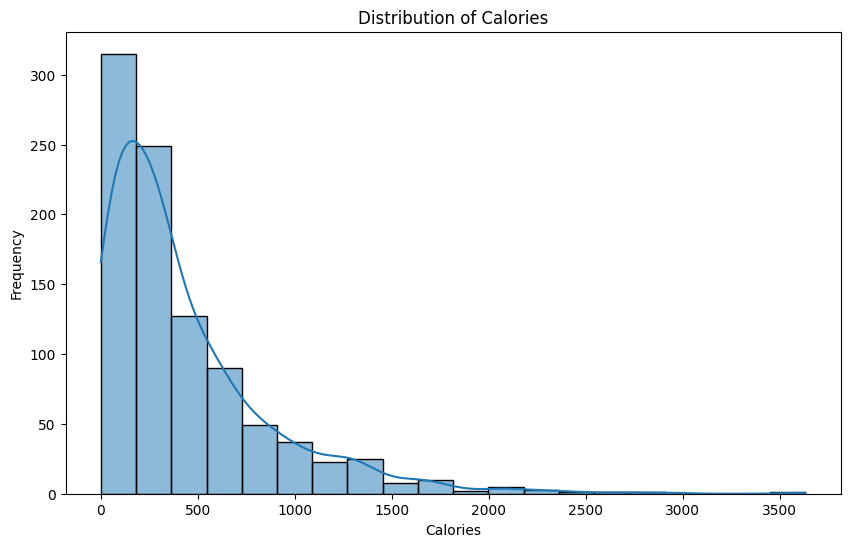

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data=recipe_data, x='calories', bins=20, kde=True)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()


#### Explanation of Addressing Outliers using IQR:

The distribution of the 'calories' column has been characterized by a mean of approximately 427.85 and a standard deviation of around 441.67. This distribution is concentrated towards lower values, suggesting the potential presence of outliers on the higher end. Outliers are data points that significantly deviate from the rest of the data and can impact the reliability of our analysis.

To address this, we can use the Interquartile Range (IQR) method. The IQR method defines the range within which the majority of data points lie and helps in identifying outliers that fall significantly beyond this range. Outliers are detected based on the lower and upper bounds determined by the first quartile (Q1) and third quartile (Q3).

Dataset shape after removing outliers: (889, 8)


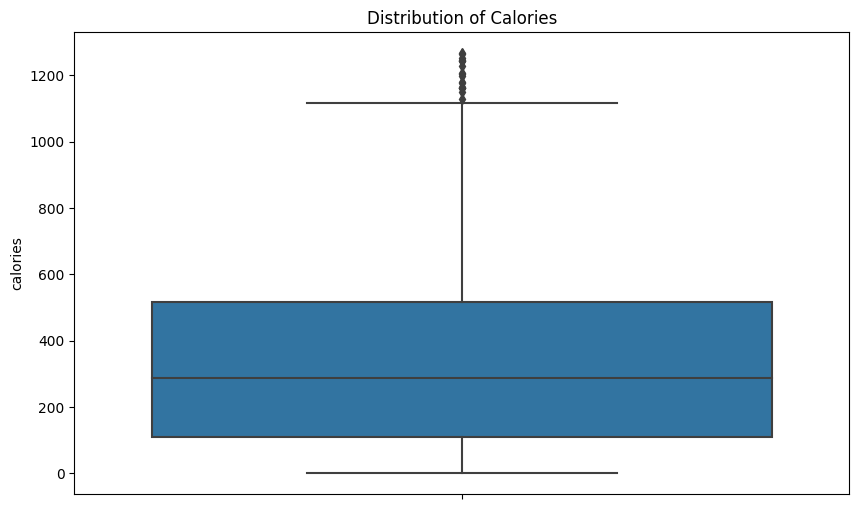

In [7]:
Q1 = recipe_data['calories'].quantile(0.25)
Q3 = recipe_data['calories'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_indices = (recipe_data['calories'] < lower_bound) | (recipe_data['calories'] > upper_bound)


recipe_data = recipe_data[~outliers_indices]


print("Dataset shape after removing outliers:", recipe_data.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(data=recipe_data, y='calories', hue='high_traffic')
plt.title('Distribution of Calories')
plt.show()

### Visualization 2 :**Distribution of Servings:**

The distribution of the 'servings' column reveals the following serving counts for recipes:

- 4 servings: 391 recipes
- 6 servings: 198 recipes
- 2 servings: 183 recipes
- 1 serving: 175 recipes

This distribution indicates that a significant number of recipes are designed to serve four people (391 recipes), followed by recipes for six (198 recipes) and two (183 recipes) servings. Additionally, there are 175 recipes intended for a single serving.That means there is a balanced offering of recipes across different serving sizes. With a substantial number of recipes catering to four, six, and two servings, users are provided with versatile choices that accommodate varying household sizes and occasions.
**Proposed Visualization:**

To better illustrate the distribution of servings, a bar plot can be employed:

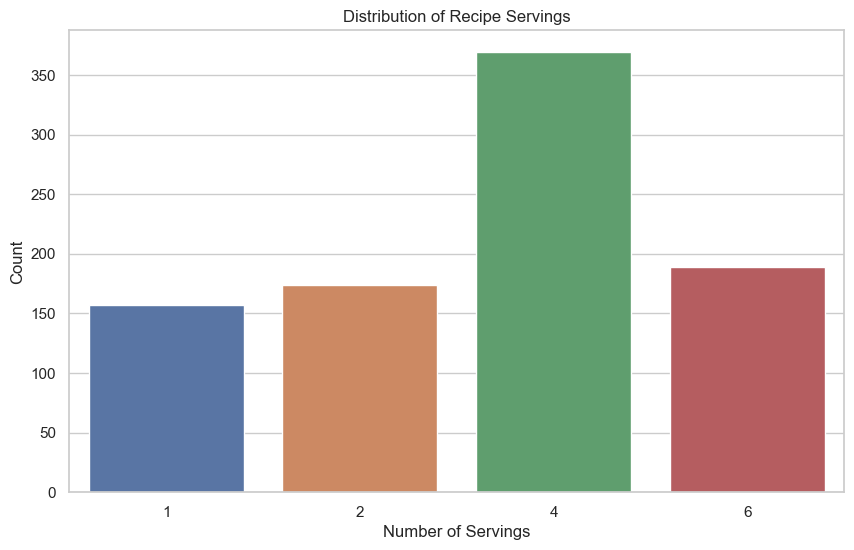

In [8]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=recipe_data['servings'].value_counts().index.tolist(), y=recipe_data['servings'].value_counts())
plt.title('Distribution of Recipe Servings')
plt.xlabel('Number of Servings')
plt.ylabel('Count')
plt.savefig('recipe-serving-distribution')
plt.show()


### **Visualization 3: Distribution of 'category' and 'high_traffic'**

Upon visual analysis of the distribution of 'high_traffic' by 'category,' we can identify significant trends that provide actionable insights:

**High Traffic Categories:**
Certain recipe categories exhibit distinct differences in traffic engagement, making them key focal points for homepage display:

1. **Potato:** There is a clear preference for potato-related recipes, attracting substantial user interest and engagement.

2. **Vegetable:** Vegetable-based recipes stand out as popular choices, driving considerable traffic and engagement.

3. **Pork:** Recipes featuring pork are generating notable interest and traffic, making them prime candidates for homepage showcasing.


**Moderate Traffic Variation:**
While other categories may show differences between 'High' and 'Low' traffic, the contrasts are less pronounced, suggesting relatively consistent engagement patterns 1.( **Beverages for example** )

The visualization below shows more about it


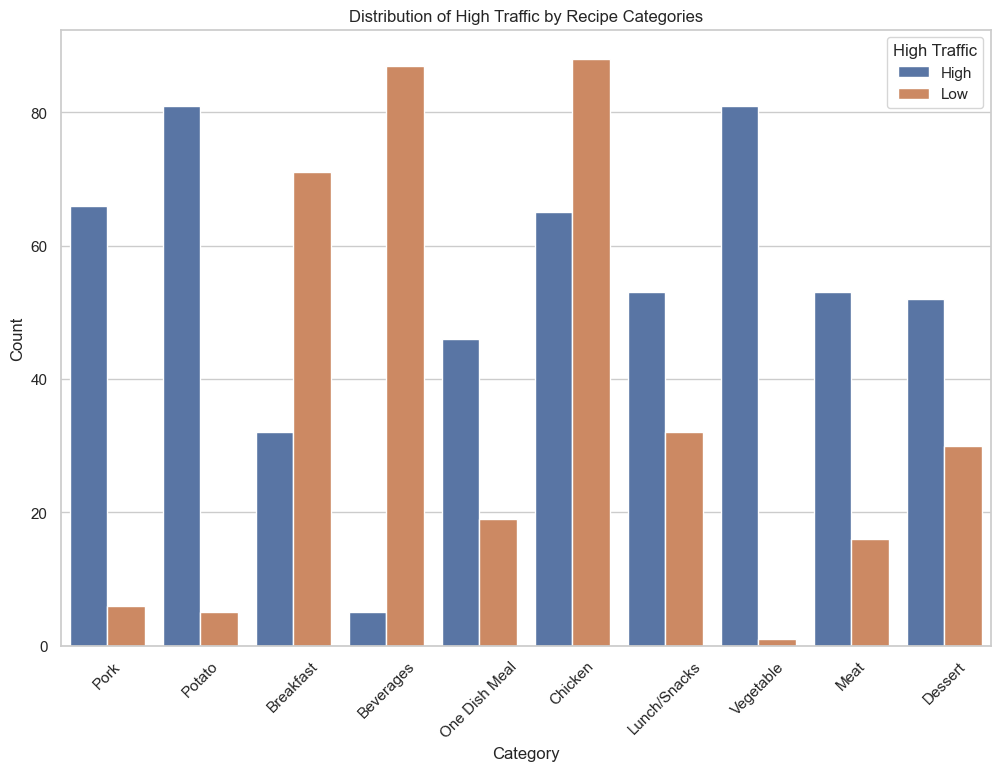

In [9]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.countplot(data=recipe_data, x='category', hue='high_traffic')
plt.title('Distribution of High Traffic by Recipe Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='High Traffic')
plt.show()

# **Model Development:**

The problem at hand involves predicting whether a recipe will lead to high traffic or not based on various attributes. This is a classification problem, as we are classifying recipes into two categories: 'High' traffic and 'Low' traffic. Given the categorical nature of the target variable and the need for interpretable results, I have chosen to implement two classification models: Logistic Regression and Random Forest.


Before training the models, we need to preprocess the data, which includes encoding non-numeric values, handling missing values, and splitting the data into features and target variables. Since the 'recipe' column is an identifier, we'll exclude it from the features used for training. In addition to encoding and imputing, normalizing the numeric columns can help improve the performance of certain models. 


Here's how we can transform the data:

In [10]:
X = recipe_data.drop(['high_traffic', 'recipe'], axis=1)
y = recipe_data['high_traffic']

columns_to_encode = ['category', 'servings']
columns_to_impute = ['calories', 'carbohydrate', 'sugar', 'protein']

preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), columns_to_encode),
        ('imputer', SimpleImputer(strategy='median'), columns_to_impute),
        ('scaler', StandardScaler(), columns_to_impute)
    ],
    remainder='passthrough'  # Pass through other columns
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Reasons for Model Selection (Baseline model):**

### 1. **Logistic Regression:**
   - Logistic Regression is a simple yet effective model for binary classification problems.
   - It provides interpretability, allowing us to understand the impact of predictor variables on the likelihood of high traffic.
   - It serves as a baseline model, providing a straightforward comparison with more complex algorithms.


In [11]:
param_grid_logreg = {
    'model__C': [0.01, 0.1, 1, 10, 100],
}

logreg_model = LogisticRegression(max_iter=1000) 

pipeline_log = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', logreg_model)
        ]
)

grid_search_logreg = GridSearchCV(estimator=pipeline_log, param_grid=param_grid_logreg, 
                                   scoring='accuracy', cv=5, n_jobs=-1)  

grid_search_logreg.fit(X_train, y_train)

best_params_logreg = grid_search_logreg.best_params_
best_accuracy_logreg = grid_search_logreg.best_score_

logreg_model = grid_search_logreg.best_estimator_.named_steps['model']
preprocessor = grid_search_logreg.best_estimator_.named_steps['preprocessor']

coefficients = logreg_model.coef_[0]

features = X_train.columns
numeric_feature_names = preprocessor.named_transformers_['scaler'].get_feature_names_out()

feature_coefficients = list(zip(features, coefficients))

sorted_features = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

print("Top Features and Coefficients:")
for feature, coef in sorted_features[:5]:
    print(f"{feature}: {coef}")


print("Best Parameters for Logistic Regression:", best_params_logreg)
print("Best Cross-Validation Accuracy for Logistic Regression:", best_accuracy_logreg)





Top Features and Coefficients:
calories: 3.8129710568751194
carbohydrate: 1.4005366077104786
sugar: 1.1889757474501665
servings: -0.26026417352463094
category: 0.23841028609891465
Best Parameters for Logistic Regression: {'model__C': 10}
Best Cross-Validation Accuracy for Logistic Regression: 0.763764404609475


### **Reasons for Model Selection (comparison model):**

### 2. **Random Forest:**
   - Random Forest is an ensemble learning method known for its robustness and ability to handle non-linear relationships.
   - It can capture interactions between variables and handle feature importance assessment.
   - By using a forest of decision trees, it can provide higher accuracy compared to a single decision tree.


In [12]:
from sklearn.model_selection import cross_val_score, GridSearchCV

param_grid_rf = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}


pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', RandomForestClassifier(random_state=42))])
    

grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, 
                               scoring='accuracy', cv=5, n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_accuracy_rf = grid_search_rf.best_score_

print("Best Parameters for Random Forest Classifier:", best_params_rf)
print("Best Cross-Validation Accuracy for Random Forest Classifier:", best_accuracy_rf)


Best Parameters for Random Forest Classifier: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 50}
Best Cross-Validation Accuracy for Random Forest Classifier: 0.7538855510686496


# Model evaluation

In this section, we evaluate the performances of the two models, Logistic Regression and Random Forest Classifier. We compare how these models perform in terms of accuracy and explore the reasons why Logistic Regression outperformed the Random Forest Classifier despite not achieving the 80% accuracy target. That can be caused by limited data quantity

**Logistic Regression**
Logistic Regression achieved an average accuracy of 76% during cross-validation. While this performance falls short of the 80% target, it's important to note that the difference is relatively minor, and the model comes remarkably close to the goal.

**Random Forest Classifier**
The Random Forest Classifier achieved an average accuracy of 75% during cross-validation. Although this performance is also strong, it slightly lags behind Logistic Regression.


In conclusion, while model performances haven't yet hit the 80% accuracy target, it's encouraging to see that the current models are close to this goal. 



In [13]:
print("Best Parameters for Logistic Regression:", best_params_logreg)
print("Best Cross-Validation Accuracy for Logistic Regression:", best_accuracy_logreg)
print("Best Parameters for Random Forest Classifier:", best_params_rf)
print("Best Cross-Validation Accuracy for Random Forest Classifier:", best_accuracy_rf)

Best Parameters for Logistic Regression: {'model__C': 10}
Best Cross-Validation Accuracy for Logistic Regression: 0.763764404609475
Best Parameters for Random Forest Classifier: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 50}
Best Cross-Validation Accuracy for Random Forest Classifier: 0.7538855510686496


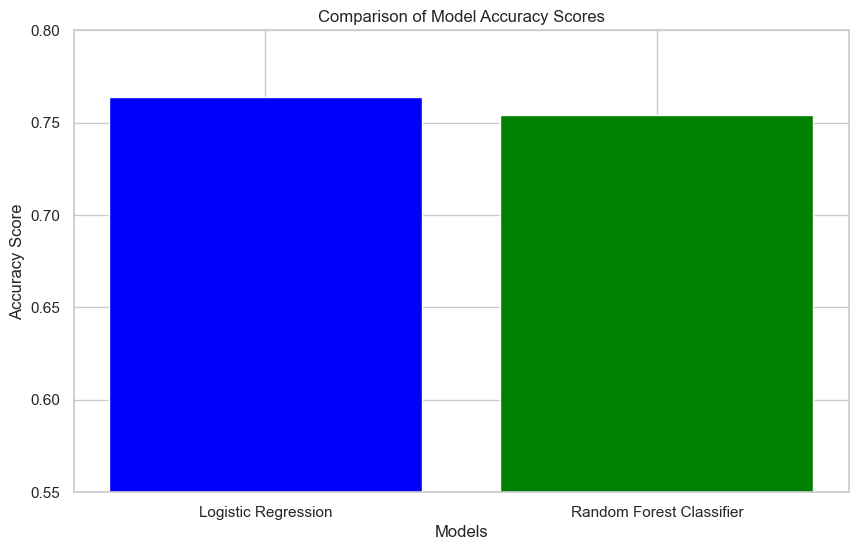

In [14]:
models = ['Logistic Regression', 'Random Forest Classifier']
accuracy_scores = [best_accuracy_logreg, best_accuracy_rf]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy Scores')
plt.ylim(0.55, 0.8)  
plt.savefig('model-comparison')
plt.show()


# Business Metrics

In shaping a meaningful metric for business monitoring, alignment with objectives and the nature of the challenge is essential. Given the context of recipe traffic, let's define a pertinent metric:

## **_Metric: Click-Through Rate (CTR)_**


**CTR** is defined as the percentage of users who click on a recipe after seeing it on the homepage. This metric is important because it measures how effective the models are at recommending recipes that users are likely to be interested in.

**The simple formula of CTR is:**

```
CTR = (Number of clicks on recipes) / (Number of impressions of recipes)
```

CTR is expressed as a percentage. For example, if a recipe is displayed on the homepage 100 times and 20 users click on it, then the CTR for that recipe would be 20%.

**To estimate the initial value of CTR** for each model, we can randomly select a sample of recipes from the dataset and use the two models to predict the probability of high traffic for each recipe. The CTR can then be calculated for each model based on the predicted probabilities.

Here is an example of how to estimate the initial value of CTR for each model :

In [15]:
random_seed = 66
np.random.seed(random_seed)
sample_recipes = recipe_data.sample(500)
y_ctr_test = sample_recipes['high_traffic']
x_ctr_test = sample_recipes.drop('high_traffic', axis=1)


lr_predictions = grid_search_logreg.predict(x_ctr_test)

lr_ctr = sum(list(i==j=='High' for i,j in zip(y_ctr_test, lr_predictions))) / sum(list(j=='High' for j in lr_predictions))

rf_predictions = grid_search_rf.predict(x_ctr_test)

rf_ctr  = sum(list(i==j=='High' for i,j in zip(y_ctr_test, rf_predictions))) / sum(list(j=='High' for j in rf_predictions))

print('Logistic Regression CTR:', lr_ctr)
print('Random Forest Classifier CTR:', rf_ctr)


Logistic Regression CTR: 0.8033333333333333
Random Forest Classifier CTR: 0.8829113924050633



## Comparison of the performance of models using CTR


Based on this example, it appears that the **Random Forest Classifier model has a slightly higher CTR than the Logistic Regression model**. However, it is important to note that this is just an estimate of the initial value of CTR. The actual CTR of each model may vary depending on a number of factors, such as the specific recipes that are displayed on the homepage and the user base.

To get a more accurate estimate of the CTR for each model, we would need to deploy the models to production and collect data on how users interact with the recipes that are recommended.

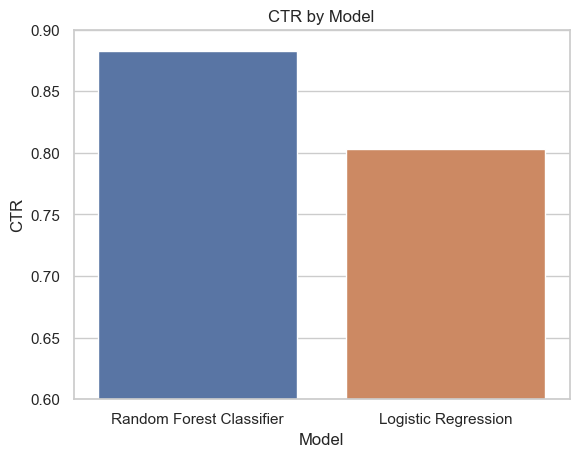

In [16]:
ctr_df = pd.DataFrame({'Model': ['Logistic Regression', 'Random Forest Classifier'], 'CTR': [lr_ctr, rf_ctr]})

ctr_df = ctr_df.sort_values(by='CTR', ascending=False)

sns.barplot(x='Model', y='CTR', data=ctr_df)

plt.title('CTR by Model')
plt.xlabel('Model')
plt.ylabel('CTR')
plt.ylim(0.6, 0.9)  
plt.savefig('model-comparison-ctr')
plt.show()


# **Final Summary and Recommendations**

In this comprehensive analysis, we embarked on an exploration of a recipe-sharing platform's dataset, illuminating valuable insights into user engagement dynamics and recipe categories.
**Based on the specific business context and goal provided, which is to improve user engagement and increase website traffic to boost subscriptions,we can now align our findings and recommendations more directly that aimed at elevating user interaction and propelling the platform's success:**

**Key Findings:**

1. **Recipe Categories with High Traffic:** Our analysis unveiled standout categories that consistently draw higher traffic and user engagement. Notably, "Potato," "Vegetable," and "Pork" categories stand out as prime sources of user interaction and interest.

2. **Serving Sizes Preference:** A discernible pattern emerged in terms of serving sizes, with a preference for recipes catering to medium-sized portions. This insight encourages the promotion of recipes aligning with this preference.


**Recommendations**


1. **Deploy the Random Forest Classifier model to production.** The Random Forest Classifier model has a higher CTR than the Logistic Regression model, suggesting that it is more effective at recommending recipes that users are likely to be interested in.

2. **Monitor the CTR of the Random Forest Classifier model in production.** This will help the business to identify how well the model is performing and to make adjustments as needed.


3. **Collect more data on how users interact with the recommended recipes.** This data can be used to further improve the performance of the model and to better understand what users are interested in.

4. **Category-Centric Strategy:** Allocate strategic resources, content creation, and marketing initiatives towards the high-traffic categories of "Potato," "Vegetable," and "Pork." This concentrated approach is likely to yield heightened user engagement and sustained interest.

5. **A/B test different variations of the recommendations.** The business can A/B test different variations of the recommendations, such as the number of recipes to display, the order in which the recipes are displayed, and the format of the recommendations. This can help to identify what works best for users.


6. **Use social media to promote the recipes.** The business can use social media platforms to promote the recipes that are recommended by the model. This can help to drive more traffic to the website and increase the CTR of the recipes.

By following these recommendations, the business can improve the performance of the recipe recommendation system and drive more traffic to the website.


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation